In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import itertools
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import yaml
import sys

from sklearn.metrics import jaccard_similarity_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

sys.path.insert(1, '/home/guilherme-resende/Desktop/mono2/utils')
import qif
from categorize import Categorize

In [2]:
sns.set()

In [3]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)

#### Load Data

In [4]:
ds_name = "adult"

In [5]:
datasets = yaml.load(open("datasets.yaml"))
df = pd.read_csv(datasets[ds_name]["path"])

pre_process = Categorize(
    df,
    binary_cols=datasets[ds_name]["binary_cols"],
    hierarchical_continuous_cols=datasets[ds_name]["hierarchical_continuous_cols"],
    non_hierarchical_cols=datasets[ds_name]["non_hierarchical_cols"]
)

df = pre_process.transform_data()

df_train = df.loc[df.set == "train"].drop("set", axis=1)
df_test = df.loc[df.set == "test"].drop("set", axis=1)

del df

/home/guilherme-resende/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: YAMLLoadWarning:

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.



In [6]:
# I'll consider dividing the training set into training and validation.
# The final model will be trained on the entire training set and tested on test set

X = df_train.drop("targets", axis=1)
Y = df_train.targets

X_test = df_test.drop("targets", axis=1)
Y_test = df_test.targets.values

#### Train XGBoost

In [7]:
xgb = XGBClassifier(max_depth=8, n_estimators=128)
xgb.fit(X.values, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=128, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [8]:
preds = xgb.predict(X_test.values)
preds_proba = xgb.predict_proba(X_test.values)[:, 1:]
df_test["preds_proba"] = preds_proba

print("Metrics:")
print("\tF1-Score ->", f1_score(Y_test, preds))
print("\tAUC ->", roc_auc_score(Y_test, preds_proba))

Metrics:
	F1-Score -> 0.6332631578947369
	AUC -> 0.8888990404811206


#### Get the SHAP scores

In [9]:
%%time

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test.values)

shap_values = shap_values.mean(axis=0)

/home/guilherme-resende/anaconda3/lib/python3.7/site-packages/shap/explainers/tree.py:114: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



CPU times: user 1min 3s, sys: 8.77 ms, total: 1min 3s
Wall time: 1min 3s


#### Get the QIF scores

In [10]:
# Discretize the probabilities
df_test["preds_proba"] = (df_test["preds_proba"] * 100).astype(int)

In [11]:
bayes_leakage = qif.BayesLeakage(df_test)
feature_names = X_test.columns

In [12]:
%%time

qif_values = []
for feature in feature_names:
    leakage = bayes_leakage.compute_flows(x=feature, y='preds_proba')
    qif_values.append(leakage[0])

qif_values = np.array(qif_values)
qif_values = qif_values / qif_values.sum() # Normalize

CPU times: user 1.67 s, sys: 0 ns, total: 1.67 s
Wall time: 1.67 s


In [13]:
qif_values

array([0.03693206, 0.02236412, 0.01875108, 0.01871919, 0.01798594,
       0.01798594, 0.01818168, 0.01798821, 0.01798594, 0.01798594,
       0.01799739, 0.01798594, 0.01798594, 0.02189917, 0.02827346,
       0.01798594, 0.01798594, 0.01798594, 0.01798594, 0.01798594,
       0.01798594, 0.01815368, 0.01798594, 0.01808944, 0.01798594,
       0.01798594, 0.01802375, 0.01798594, 0.01798594, 0.01798594,
       0.01798594, 0.01812679, 0.02486291, 0.01798594, 0.01817144,
       0.01798594, 0.01798594, 0.01798594, 0.01798594, 0.01798594,
       0.01798594, 0.01798594, 0.01798594, 0.01798594, 0.01798594,
       0.01798594, 0.01798594, 0.01798594, 0.01798594, 0.01798594,
       0.01798594, 0.01798594, 0.01798594])

In [14]:
feat_coefs_qif = {name: coef for name, coef in zip(feature_names, qif_values)}

#### Train a Linear Model

In [15]:
logit = LogisticRegression()
logit.fit(X.values, Y)

/home/guilherme-resende/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
preds = logit.predict(X_test.values)
preds_proba = logit.predict_proba(X_test.values)[:, 1:]
df_test["preds_proba"] = preds_proba

print("Metrics:")
print("\tF1-Score ->", f1_score(Y_test, preds))
print("\tAUC ->", roc_auc_score(Y_test, preds_proba))

Metrics:
	F1-Score -> 0.606633692173407
	AUC -> 0.8833635476500684


In [17]:
logit_values = vars(logit)["coef_"].reshape(-1)

In [18]:
logit_values

array([ 0.19169862,  0.30093495,  0.9205826 ,  0.22732215, -0.69925597,
       -1.00445588, -0.40432819,  0.09857078, -0.51916616, -0.68647661,
       -0.18682344, -0.48956841, -0.04599588, -1.39552147,  0.72792232,
       -0.8861003 , -0.99450051, -0.99848784,  0.38791607, -0.77872806,
       -0.34187975,  0.5250658 , -0.9895294 ,  0.27307143, -1.22687079,
        0.00593265, -0.21389746, -0.42488949, -0.22918744, -0.58284284,
       -0.73247249, -0.47204545, -0.62438411,  0.75563566, -1.63049564,
       -0.71089071, -1.25531954, -0.51383369, -0.61358786, -0.53743601,
       -1.14183515, -1.13080708, -0.20863683, -0.12118206, -0.51668824,
       -0.64788673, -0.44547996, -0.8641811 , -0.6545316 , -0.09044886,
       -0.01629976,  0.14076881, -0.51293346])

In [19]:
feat_coefs_logit = {name: coef for name, coef in zip(feature_names, logit_values)}

#### Comparison Between Importances

In [20]:
feat_coefs_logit = dict(
    sorted(
        feat_coefs_logit.items(),
        key=lambda item: abs(item[1]),
        reverse=True
    )
)

feat_coefs_qif = dict(
    sorted(
        feat_coefs_qif.items(),
        key=lambda item: abs(item[1]),
        reverse=True
    )
)

In [21]:
jaccard_at_k = []

for k in range(2, len(feat_coefs_logit)):
    jaccard_at_k.append(
        jaccard_similarity_score(
            list(feat_coefs_logit.keys())[:k],
            list(feat_coefs_qif.keys())[:k]
        )
    )

jaccard_at_k = np.round(jaccard_at_k, 3)

/home/guilherme-resende/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:664: FutureWarning:

jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.



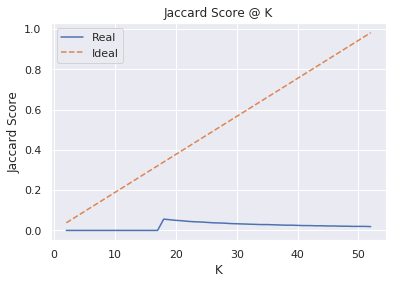

In [22]:
x = range(2, len(feat_coefs_logit))

plt.plot(x, jaccard_at_k, label="Real")
plt.plot(x, np.array(x)/len(feat_coefs_logit), linestyle="--", label="Ideal")
plt.title("Jaccard Score @ K")
plt.xlabel("K")
plt.ylabel("Jaccard Score")
plt.legend()
plt.show()

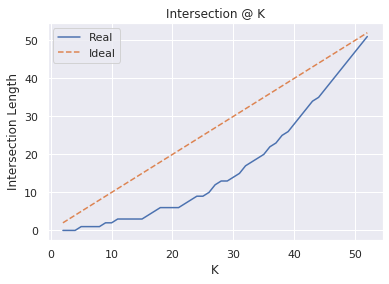

In [23]:
intersection_at_k = []

for k in range(2, len(feat_coefs_logit)):
    intersection_at_k.append(
        len(
            set(
                list(feat_coefs_logit.keys())[:k]
            ).intersection(list(feat_coefs_qif.keys())[:k])
        )
    )

plt.plot(range(2, len(feat_coefs_logit)), intersection_at_k, label="Real")
plt.plot(range(2, len(feat_coefs_logit)), range(2, len(feat_coefs_logit)), linestyle="--", label="Ideal")
plt.title("Intersection @ K")
plt.xlabel("K")
plt.ylabel("Intersection Length")
plt.legend()
plt.show()